In [3]:
# from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2 ##STrAdaBoost.R2
# from TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2 ##two-stage TrAdaBoost.R2

import pandas as pd
import sys
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from scipy.stats.stats import pearsonr
from math import sqrt
import statistics 
from scipy.stats import *
from scipy.spatial import distance

######### Instance Transfer repositories ####################
from adapt.instance_based import TrAdaBoost, TrAdaBoostR2, TwoStageTrAdaBoostR2
from sklearn.model_selection import GridSearchCV
from adapt.instance_based import KMM

print("Repositories uploaded!!")

Repositories uploaded!!


In [4]:
################################### Concrete ###########################################################################################################
ConcreteData_df = pd.read_excel('UCI_regression/Concrete/Concrete_Data.xls') ## 'Cement' found to be correlated at 0.4 :: 100
print("Concrete Data")
print("-------------------------------------------")
print(ConcreteData_df.shape)


##############################################################################################
# concrete_cols = ConcreteData_df.columns
# ss = StandardScaler()
# ConcreteData_df[concrete_cols] = ss.fit_transform(ConcreteData_df[concrete_cols])
# print(ConcreteData_df)


drop_col_concrete = ['Cement']

concrete_tgt_df = ConcreteData_df.loc[(ConcreteData_df['Cement'] <= 225)]
concrete_tgt_df = concrete_tgt_df.drop(drop_col_concrete, axis = 1)
concrete_tgt_df = concrete_tgt_df.reset_index(drop=True)
print("Target : ",concrete_tgt_df.shape)

concrete_source1_df = ConcreteData_df.loc[(ConcreteData_df['Cement'] > 225) & (ConcreteData_df['Cement'] <= 350)]
concrete_source1_df = concrete_source1_df.drop(drop_col_concrete, axis = 1)
concrete_source1_df = concrete_source1_df.reset_index(drop=True)
print("Source 1: ",concrete_source1_df.shape)

concrete_source2_df = ConcreteData_df.loc[(ConcreteData_df['Cement'] > 350)]
concrete_source2_df = concrete_source2_df.drop(drop_col_concrete, axis = 1)
concrete_source2_df = concrete_source2_df.reset_index(drop=True)
print("Source 2: ",concrete_source2_df.shape)

################################# Standardization ############################
from sklearn.preprocessing import StandardScaler
concrete_cols = concrete_tgt_df.columns.difference(['ConcreteCompressiveStrength'])

ss = StandardScaler()
concrete_tgt_df[concrete_cols] = ss.fit_transform(concrete_tgt_df[concrete_cols])
concrete_source1_df[concrete_cols] = ss.fit_transform(concrete_source1_df[concrete_cols])
concrete_source2_df[concrete_cols] = ss.fit_transform(concrete_source2_df[concrete_cols])


############################ Concatenating the source datasets ############################
concrete_source_df = pd.concat([concrete_source1_df, concrete_source2_df], ignore_index = True)
concrete_source_df = concrete_source_df.reset_index(drop = True)


#################### Splitting into features and target ####################
target_concrete = ['ConcreteCompressiveStrength']

concrete_source_df_y = concrete_source_df[target_concrete]
concrete_source_df_X = concrete_source_df.drop(target_concrete, axis = 1)

features_concrete = concrete_source_df_X.columns
################################################################################################################################################################

Concrete Data
-------------------------------------------
(1030, 9)
Target :  (368, 8)
Source 1:  (406, 8)
Source 2:  (256, 8)


In [50]:
########################### TwoStagetrAdaBoostR2 Concrete #######################################

from adapt.instance_based import TrAdaBoost, TrAdaBoostR2, TwoStageTrAdaBoostR2

def get_estimator(**kwargs):
    return DecisionTreeRegressor(max_depth = 6)

kwargs_TwoTrAda = {'steps': 30,
                    'fold': 10,
                  'learning_rate': 0.1}

print("Specification for TrAdaboost.R2 requirement complete!")

##################################################################################################

print("Two-Stage TrAdaboost.R2")
print("-------------------------------------------")

r2scorelist_TwoTrAda_concrete = []
rmselist_TwoTrAda_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    concrete_X_df = pd.concat([concrete_source_df_X, concrete_train_df_X], ignore_index=True)
    concrete_y_df = pd.concat([concrete_source_df_y, concrete_train_df_y], ignore_index=True)

    concrete_np_train_X = concrete_X_df.to_numpy()
    concrete_np_train_y = concrete_y_df.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()

    src_size_concrete = len(concrete_source_df_y)
    tgt_size_concrete = len(concrete_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_concrete - 1), step=1)
    tgt_idx = np.arange(start = src_size_concrete, stop = ((src_size_concrete + tgt_size_concrete)-1), step=1)


    model_TwoTrAda_concrete = TwoStageTrAdaBoostR2(get_estimator = get_estimator, n_estimators = 100) #, cv = 10) 
    model_TwoTrAda_concrete.fit(concrete_np_train_X, concrete_np_train_y_list, src_idx, tgt_idx)

    y_pred_TwoTrAda_concrete = model_TwoTrAda_concrete.predict(concrete_np_test_X)
    
    mse_TwoTrAda_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_TwoTrAda_concrete))
    rmselist_TwoTrAda_concrete.append(mse_TwoTrAda_concrete)
        
    r2_score_TwoTrAda_concrete = pearsonr(concrete_np_test_y_list, y_pred_TwoTrAda_concrete)
    r2_score_TwoTrAda_concrete = (r2_score_TwoTrAda_concrete[0])**2
    r2scorelist_TwoTrAda_concrete.append(r2_score_TwoTrAda_concrete)


print("RMSE List of Two-Stage TrAdaboost.R2:", rmselist_TwoTrAda_concrete)
print("R^2 List of TrAdaboostR2:", r2scorelist_TwoTrAda_concrete)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_TwoTrAda_concrete), statistics.stdev(rmselist_TwoTrAda_concrete))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_TwoTrAda_concrete), statistics.stdev(r2scorelist_TwoTrAda_concrete))


print("-------------------------------------------")

Specification for TrAdaboost.R2 requirement complete!
Two-Stage TrAdaboost.R2
-------------------------------------------
Binary search has not converged. Set value to the current best.
RMSE List of Two-Stage TrAdaboost.R2: [5.809211408696263, 7.789066720392749, 8.957489047138598, 8.263744616657963, 8.760590871962252, 6.889771112642312, 6.085981882299316, 5.799087003967696, 5.602282791650463, 5.631358842544836]
R^2 List of TrAdaboostR2: [0.8120508206082601, 0.6500653970810222, 0.7118824741791502, 0.6601635119289769, 0.7906092117479931, 0.6802344210649145, 0.797685700198735, 0.7235199217672004, 0.5507047981805997, 0.6609043092340013]
Mean, STDev of RMSE: 6.958858429795245 1.360912074806487
Mean, STDev of R^2: 0.7037820565990853 0.0810677842927172
-------------------------------------------


In [9]:
#################################### STrAdaBoost.R2 Active Sampling Concrete ################################################################
from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2

n_estimators = 100
steps = 30
fold = 20

r2scorelist_stradaboost_concrete = []
rmselist_stradaboost_concrete = []

print("STrAdaboost.R2")
print("-------------------------------------------")


kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    concrete_X_df = pd.concat([concrete_source_df_X, concrete_train_df_X], ignore_index=True)
    concrete_y_df = pd.concat([concrete_source_df_y, concrete_train_df_y], ignore_index=True)

    concrete_np_train_X = concrete_X_df.to_numpy()
    concrete_np_train_y = concrete_y_df.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()
    
    sample_size = [len(concrete_source_df_X), len(concrete_train_df_X)]


    model_stradaboost_concrete = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth = 6),
                        n_estimators = n_estimators, sample_size = sample_size,
                        steps = steps, fold = fold)


    model_stradaboost_concrete.fit(concrete_np_train_X, concrete_np_train_y_list)
    y_pred_stradaboost_concrete = model_stradaboost_concrete.predict(concrete_np_test_X)


    mse_stradaboost_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_stradaboost_concrete))
    rmselist_stradaboost_concrete.append(mse_stradaboost_concrete)
        
    r2_score_stradaboost_concrete = pearsonr(concrete_np_test_y_list, y_pred_stradaboost_concrete)
    r2_score_stradaboost_concrete = (r2_score_stradaboost_concrete[0])**2
    r2scorelist_stradaboost_concrete.append(r2_score_stradaboost_concrete)


print("RMSE List of STrAdaboost.R2:", rmselist_stradaboost_concrete)
print("R^2 List of STrAdaboost.R2:", r2scorelist_stradaboost_concrete)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_stradaboost_concrete), statistics.stdev(rmselist_stradaboost_concrete))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_stradaboost_concrete), statistics.stdev(r2scorelist_stradaboost_concrete))


STrAdaboost.R2
-------------------------------------------
Inside Updated Sampling TrAdaBoost.R2
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
First revision introduced!
Inside Updated Sampling TrAdaBoost.R2
First revision introduced!
First revision introduced!
F

In [4]:
######################### Gradient Boosting Regression Transfer Learning Concrete #######################################

from sklearn.ensemble import GradientBoostingRegressor


print("Gradient Boosting Regression Transfer Learning")
print("-------------------------------------------")

r2scorelist_GBRTL_concrete = []
rmselist_GBRTL_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    concrete_X_df = pd.concat([concrete_source_df_X, concrete_train_df_X], ignore_index=True)
    concrete_y_df = pd.concat([concrete_source_df_y, concrete_train_df_y], ignore_index=True)

    concrete_np_train_X = concrete_X_df.to_numpy()
    concrete_np_train_y = concrete_y_df.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()


    model_GBRTL_concrete = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100)
    model_GBRTL_concrete.fit(concrete_np_train_X, concrete_np_train_y_list)

    y_pred_GBRTL_concrete = model_GBRTL_concrete.predict(concrete_test_df_X) ##Using dataframe instead of the numpy matrix
    
    mse_GBRTL_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_GBRTL_concrete))
    rmselist_GBRTL_concrete.append(mse_GBRTL_concrete)
        
    r2_score_GBRTL_concrete = pearsonr(concrete_np_test_y_list, y_pred_GBRTL_concrete)
    r2_score_GBRTL_concrete = (r2_score_GBRTL_concrete[0])**2
    r2scorelist_GBRTL_concrete.append(r2_score_GBRTL_concrete)


print("RMSE List of GBRTL:", rmselist_GBRTL_concrete)
print("R^2 List of GBRTL:", r2scorelist_GBRTL_concrete)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_GBRTL_concrete), statistics.stdev(rmselist_GBRTL_concrete))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_GBRTL_concrete), statistics.stdev(r2scorelist_GBRTL_concrete))

print("-------------------------------------------")

Gradient Boosting Regression Transfer Learning
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434

RMSE List of GBRTL: [4.515900133547423, 6.210888075169717, 11.106553564755211, 5.4387640270864255, 8.736268180436614, 6.651579682770761, 7.569485973285755, 5.721255297352209, 5.924887590435582, 4.228793444505553, 6.904398932197838, 2.228612660557733, 3.2416230725746726, 2.7184888202522903, 3.646487449836652, 2.6163093112480342, 3.0562610932156598, 5.487844230567313, 2.3974127443453592, 3.3803243903341977]
R^2 List of GBRTL: [0.948425804686607, 0.6517085074672222, 0.4062170357132619, 0.8166978291188532, 0.7155094772890215, 0.8906731339754911, 0.645851504650881, 0.4052614707560652, 0.7468216868330175, 0.9358695449368434, 0.7421593141277638, 0.9621149559631862, 0.9541496141859611, 0.9640332927063733, 0.8986326011576428, 0.9216748677859443, 0.9005107662119758, 0.6674720122760992, 0.9498949259870788, 0.8877494078243132]


Mean, STDev of RMSE: 5.08910693372375 2.348748570144169
Mean, STDev of R^2: 0.8005713876826801 0.17445409818476312
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [8]:
########################### AdaBoostR2 Transfer Learning Concrete #####################################################

from sklearn.ensemble import AdaBoostRegressor


print("Adaboost.R2 Transfer Learning")
print("-------------------------------------------")

r2scorelist_AdaTL_concrete = []
rmselist_AdaTL_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    concrete_X_df = pd.concat([concrete_source_df_X, concrete_train_df_X], ignore_index=True)
    concrete_y_df = pd.concat([concrete_source_df_y, concrete_train_df_y], ignore_index=True)

    concrete_np_train_X = concrete_X_df.to_numpy()
    concrete_np_train_y = concrete_y_df.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()


    model_AdaTL_concrete = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_AdaTL_concrete.fit(concrete_np_train_X, concrete_np_train_y_list)
    
    y_pred_AdaTL_concrete = model_AdaTL_concrete.predict(concrete_np_test_X)
    
    mse_AdaTL_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_AdaTL_concrete))
    rmselist_AdaTL_concrete.append(mse_AdaTL_concrete)
        
    r2_score_AdaTL_concrete = pearsonr(concrete_np_test_y_list, y_pred_AdaTL_concrete)
    r2_score_AdaTL_concrete = (r2_score_AdaTL_concrete[0])**2
    r2scorelist_AdaTL_concrete.append(r2_score_AdaTL_concrete)
    

print("RMSE List of Adaboost.R2:", rmselist_AdaTL_concrete)
print("R^2 List of TrAdaboostR2:", r2scorelist_AdaTL_concrete)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_AdaTL_concrete), statistics.stdev(rmselist_AdaTL_concrete))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_AdaTL_concrete), statistics.stdev(r2scorelist_AdaTL_concrete))


print("-------------------------------------------")

Adaboost.R2 Transfer Learning
-------------------------------------------
RMSE List of Adaboost.R2: [4.971678335785356, 4.050848823930435, 11.010233910021816, 5.6851970093267274, 7.716322228981622, 7.629343552697231, 7.158032975984863, 5.857658798998065, 4.062017132325135, 5.229707744399672, 7.497593408557027, 4.221068427604768, 5.1043846928798695, 5.127297457086784, 5.208835016212533, 5.935554715161531, 5.016325446832422, 8.122051439460494, 4.958353300738871, 5.327307648866592]
R^2 List of TrAdaboostR2: [0.9576526478008768, 0.8740324433260943, 0.41468583025646266, 0.7955998313349472, 0.7779544932321402, 0.9053067277466689, 0.608483744068395, 0.3160048064903876, 0.743353502917773, 0.9077652622565813, 0.7472879017958575, 0.9062261004927639, 0.8859144041933634, 0.8931975435408611, 0.812889676957114, 0.7773127948996449, 0.7921793405102375, 0.49800737019525704, 0.8986236291661793, 0.7485485000589447]


Mean, STDev of RMSE: 5.994490603292591 1.7164529071133592
Mean, STDev of R^2: 0.76305132

In [30]:
########################### Regular AdaBoostR2 Concrete #####################################################
from sklearn.ensemble import AdaBoostRegressor


print("Regular Adaboost.R2")
print("-------------------------------------------")

r2scorelist_Ada_concrete = []
rmselist_Ada_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
    
    concrete_np_train_X = concrete_train_df_X.to_numpy()
    concrete_np_train_y = concrete_train_df_y.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()
    
    model_Ada_concrete = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_Ada_concrete.fit(concrete_train_df_X, concrete_train_df_y)
    
    y_pred_Ada_concrete = model_Ada_concrete.predict(concrete_np_test_X)
    
    mse_Ada_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_Ada_concrete))
    rmselist_Ada_concrete.append(mse_Ada_concrete)
        
    r2_score_Ada_concrete = pearsonr(concrete_np_test_y_list, y_pred_Ada_concrete)
    r2_score_Ada_concrete = (r2_score_Ada_concrete[0])**2
    r2scorelist_Ada_concrete.append(r2_score_Ada_concrete)

print("RMSE List of Adaboost.R2:", rmselist_Ada_concrete)
print("R^2 List of AdaboostR2:", r2scorelist_Ada_concrete)

print("\n")

print("RMSE of Adaboost.R2:", statistics.mean(rmselist_Ada_concrete), statistics.stdev(rmselist_Ada_concrete))
print("R^2 of AdaboostR2:", statistics.mean(r2scorelist_Ada_concrete), statistics.stdev(r2scorelist_Ada_concrete))


print("-------------------------------------------")

Regular Adaboost.R2
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validat

RMSE List of Adaboost.R2: [4.748099173416622, 4.193142739067393, 9.80807404544599, 6.613389246521382, 5.177454123552435, 10.880350401818246, 8.164593651147321, 7.781811825844132, 6.180351368300683, 4.588869053658558, 7.136203126696669, 4.240250832578044, 5.175834045634039, 4.969144673621939, 4.591976195780937, 4.005867620045321, 3.5528526941331147, 4.951957625096265, 3.0134378854019137, 4.694470720418787]
R^2 List of AdaboostR2: [0.9429491450341873, 0.8693517059043606, 0.49451256932132903, 0.769372578024711, 0.8749279839519757, 0.8422515038192517, 0.6252595143214322, 0.3731101694196606, 0.6208619874457955, 0.9150277702008566, 0.7044111686616642, 0.8635940458595132, 0.8410010813588894, 0.8794088118751837, 0.8546322271851177, 0.8308758104604077, 0.8387128527726913, 0.7193107915791445, 0.9198335282746206, 0.7789291776915598]


RMSE of Adaboost.R2: 5.723406552408989 2.0819738487138593
R^2 of AdaboostR2: 0.7779167211581176 0.14923690697886408
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [28]:
######################### Regular Gradient Boosting Regression Concrete #######################################

from sklearn.ensemble import GradientBoostingRegressor


print("Regular Gradient Boosting Regression")
print("-------------------------------------------")

r2scorelist_GBR_concrete = []
rmselist_GBR_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
    
    concrete_np_train_X = concrete_train_df_X.to_numpy()
    concrete_np_train_y = concrete_train_df_y.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()

    model_GBR_concrete = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100, subsample=0.5)
    model_GBR_concrete.fit(concrete_train_df_X, concrete_train_df_y)

    y_pred_GBR_concrete = model_GBR_concrete.predict(concrete_test_df_X) ##Using dataframe instead of the numpy matrix
    
    mse_GBR_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_GBR_concrete))
    rmselist_GBR_concrete.append(mse_GBR_concrete)
        
    r2_score_GBR_concrete = pearsonr(concrete_np_test_y_list, y_pred_GBR_concrete)
    r2_score_GBR_concrete = (r2_score_GBR_concrete[0])**2
    r2scorelist_GBR_concrete.append(r2_score_GBR_concrete)

print("RMSE of GBR:", rmselist_GBR_concrete)
print("R^2 of GBR:", r2scorelist_GBR_concrete)

print("\n")

print("RMSE of GBR:", statistics.mean(rmselist_GBR_concrete), statistics.stdev(rmselist_GBR_concrete))
print("R^2 of GBR:", statistics.mean(r2scorelist_GBR_concrete), statistics.stdev(r2scorelist_GBR_concrete))

print("-------------------------------------------")

Regular Gradient Boosting Regression
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

RMSE of GBR: [5.901930671157144, 5.15337288272756, 9.265388049083601, 5.738781819708581, 5.5256500594423965, 9.774874451372645, 8.935231598947555, 6.859322120694691, 5.7393575272356, 4.028620374862914, 8.95317594139937, 2.2334276157948123, 3.7365644569260983, 3.0168474523839337, 2.167892596744059, 1.3718077127916302, 2.721870229734329, 4.807620069095459, 1.1216067790127804, 1.2942313635899643]
R^2 of GBR: [0.9105964696442186, 0.8074813612958679, 0.5347861111395603, 0.8110548508652644, 0.8583022687839148, 0.8407367941548819, 0.5467881243304514, 0.5786039807666902, 0.6748558944752804, 0.9544245180763558, 0.5813070503951928, 0.9710642366143599, 0.9177991009409214, 0.9612368871656646, 0.9702060358500241, 0.9788516462624213, 0.8912714113904493, 0.7716571847598206, 0.9847584011713646, 0.98610265654788]


RMSE of GBR: 4.917378688635257 2.781004523310294
R^2 of GBR: 0.8265942492315292 0.1592957121538132
-------------------------------------------


In [9]:
######################### Kernel Mean Matching Concrete #######################################

from adapt.instance_based import KMM


print("Kernel Mean Matching")
print("-------------------------------------------")

r2scorelist_KMM_concrete = []
rmselist_KMM_concrete = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    concrete_np_train_X = concrete_train_df_X.to_numpy()
    concrete_np_train_y = concrete_train_df_y.to_numpy()

    concrete_np_source_X = concrete_source_df_X.to_numpy()
    concrete_np_source_y = concrete_source_df_y.to_numpy()


    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()
    
    src_size_concrete = len(concrete_source_df_y)
    tgt_size_concrete = len(concrete_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_concrete - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_concrete - 1), step=1)


    model_KMM_concrete = KMM(estimator = DecisionTreeRegressor(max_depth = 6))
    model_KMM_concrete.fit(concrete_np_source_X[src_idx], concrete_np_source_y[src_idx], concrete_np_train_X[tgt_idx], concrete_np_train_y[tgt_idx])

    y_pred_KMM_concrete = model_KMM_concrete.predict(concrete_test_df_X) ##Using dataframe instead of the numpy matrix
    
    mse_KMM_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_KMM_concrete))
    rmselist_KMM_concrete.append(mse_KMM_concrete)
        
    r2_score_KMM_concrete = pearsonr(concrete_np_test_y_list, y_pred_KMM_concrete)
    r2_score_KMM_concrete = (r2_score_KMM_concrete[0])**2
    r2scorelist_KMM_concrete.append(r2_score_KMM_concrete)

print("RMSE List of KMM:", rmselist_KMM_concrete)
print("R^2 List of KMM:", r2scorelist_KMM_concrete)

print("\n")

print("RMSE of KMM:", statistics.mean(rmselist_KMM_concrete), statistics.stdev(rmselist_KMM_concrete))
print("R^2 of KMM:", statistics.mean(r2scorelist_KMM_concrete), statistics.stdev(r2scorelist_KMM_concrete))

print("-------------------------------------------")

Kernel Mean Matching
-------------------------------------------
Fit weights...
     pcost       dcost       gap    pres   dres
 0: -4.5426e+04 -7.3445e+07  8e+07  5e-03  7e-15
 1: -2.5276e+04 -1.4002e+06  1e+06  5e-05  2e-15
 2: -3.1024e+04 -2.8143e+05  3e+05  9e-06  8e-16
 3: -5.2630e+04 -1.7924e+05  1e+05  2e-07  7e-16
 4: -5.5094e+04 -8.8084e+04  3e+04  4e-08  7e-16
 5: -5.6627e+04 -6.8578e+04  1e+04  2e-16  7e-16
 6: -5.7519e+04 -6.0887e+04  3e+03  2e-16  7e-16
 7: -5.7887e+04 -5.9225e+04  1e+03  2e-16  7e-16
 8: -5.8043e+04 -5.8581e+04  5e+02  2e-16  7e-16
 9: -5.8117e+04 -5.8339e+04  2e+02  2e-16  8e-16
10: -5.8153e+04 -5.8239e+04  9e+01  2e-16  7e-16
11: -5.8171e+04 -5.8196e+04  3e+01  2e-16  7e-16
12: -5.8178e+04 -5.8182e+04  5e+00  2e-16  7e-16
13: -5.8179e+04 -5.8180e+04  8e-01  1e-16  7e-16
14: -5.8180e+04 -5.8180e+04  1e-01  2e-16  7e-16
15: -5.8180e+04 -5.8180e+04  2e-03  2e-16  8e-16
Optimal solution found.
Fit Estimator...
Fit weights...
     pcost       dcost       gap

In [15]:
######################### KLIEP Concrete #######################################

from adapt.instance_based import KLIEP


print("KLIEP")

r2scorelist_KLIEP_concrete = []
rmselist_KLIEP_concrete = []

kf = KFold(n_splits = 20)


for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
        
    
    concrete_np_train_X = concrete_train_df_X.to_numpy()
    concrete_np_train_y = concrete_train_df_y.to_numpy()

    concrete_np_source_X = concrete_source_df_X.to_numpy()
    concrete_np_source_y = concrete_source_df_y.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()
    
    src_size_concrete = len(concrete_source_df_y)
    tgt_size_concrete = len(concrete_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_concrete - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_concrete - 1), step=1)
    
    model_KLIEP_concrete = KLIEP(DecisionTreeRegressor(max_depth = 6), sigmas = [0.1, 1, 10])
    model_KLIEP_concrete.fit(concrete_np_source_X[src_idx], concrete_np_source_y[src_idx], concrete_np_train_X[tgt_idx], concrete_np_train_y[tgt_idx])

    y_pred_KLIEP_concrete = model_KLIEP_concrete.predict(concrete_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_KLIEP_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_KLIEP_concrete))
    rmselist_KLIEP_concrete.append(mse_KLIEP_concrete)

    r2_score_KLIEP_concrete = pearsonr(concrete_np_test_y_list, y_pred_KLIEP_concrete)
    r2_score_KLIEP_concrete = (r2_score_KLIEP_concrete[0])**2
    r2scorelist_KLIEP_concrete.append(r2_score_KLIEP_concrete)

print("RMSE List of KLIEP:", rmselist_KLIEP_concrete)
print("R^2 List of KLIEP:", r2scorelist_KLIEP_concrete)

print("\n")

print("RMSE of KLIEP:", statistics.mean(rmselist_KLIEP_concrete), statistics.stdev(rmselist_KLIEP_concrete))
print("R^2 of KLIEP:", statistics.mean(r2scorelist_KLIEP_concrete), statistics.stdev(r2scorelist_KLIEP_concrete))

print("-------------------------------------------")

KLIEP
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.094 (0.042)
Parameter sigma = 1.0000 -- J-score = 0.726 (0.083)
Parameter sigma = 10.0000 -- J-score = -5.896 (1.260)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.061 (0.020)
Parameter sigma = 1.0000 -- J-score = 0.590 (0.186)
Parameter sigma = 10.0000 -- J-score = -6.937 (1.598)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.070 (0.013)
Parameter sigma = 1.0000 -- J-score = 0.644 (0.069)
Parameter sigma = 10.0000 -- J-score = -6.490 (1.097)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.063 (0.029)
Parameter sigma = 1.0000 -- J-score = 0.461 (0.184)
Parameter sigma = 10.0000 -- J-score = -7.267 (0.887)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.043 (0.059)
Parameter sigma = 1.0000 --

In [13]:
#################################### Instance_KRR Concrete ################################################################
from IW_KRR import InstanceKRR

n_estimators = 100
steps = 30
fold = 20

r2scorelist_IWKRR_concrete = []
rmselist_IWKRR_concrete = []

print("IWKRR")
print("-------------------------------------------")


kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(concrete_tgt_df):
        
    concrete_train_df_X = concrete_tgt_df.iloc[train_idx].loc[:, features_concrete]
    concrete_test_df_X = concrete_tgt_df.iloc[test_idx][features_concrete]
    concrete_train_df_y = concrete_tgt_df.iloc[train_idx].loc[:,target_concrete]
    concrete_test_df_y = concrete_tgt_df.loc[test_idx][target_concrete]
    
    concrete_np_tgt_X = concrete_train_df_X.to_numpy()
    concrete_np_tgt_y = concrete_train_df_y.to_numpy()

        
    concrete_X_df = pd.concat([concrete_source_df_X, concrete_train_df_X], ignore_index=True)
    concrete_y_df = pd.concat([concrete_source_df_y, concrete_train_df_y], ignore_index=True)

    concrete_np_train_X = concrete_X_df.to_numpy()
    concrete_np_train_y = concrete_y_df.to_numpy()

    concrete_np_test_X = concrete_test_df_X.to_numpy()
    concrete_np_test_y = concrete_test_df_y.to_numpy()

    concrete_np_train_y_list = concrete_np_train_y.ravel()
    concrete_np_test_y_list = concrete_np_test_y.ravel()
    
    sample_size = [len(concrete_source_df_X), len(concrete_train_df_X)]

    model_IWKRR_concrete = InstanceKRR(lmbd = 0.5, kernel = 'rbf', gamma = None, degree = 3, coef0 = 1, kernel_params = None)
    model_IWKRR_concrete.fit(concrete_np_train_X, concrete_np_train_y_list)
    model_IWKRR_concrete.Solve_alpha(concrete_np_tgt_X,concrete_np_tgt_y)
    
    y_pred_IWKRR_concrete = model_IWKRR_concrete.predict(concrete_np_test_X)
    y_pred_IWKRR_concrete = [item for sublist in y_pred_IWKRR_concrete for item in sublist]


    mse_IWKRR_concrete = sqrt(mean_squared_error(concrete_np_test_y, y_pred_IWKRR_concrete))
    rmselist_IWKRR_concrete.append(mse_IWKRR_concrete)
        
    r2_score_IWKRR_concrete = pearsonr(concrete_np_test_y_list, y_pred_IWKRR_concrete)
    r2_score_IWKRR_concrete = (r2_score_IWKRR_concrete[0])**2
    r2scorelist_IWKRR_concrete.append(r2_score_IWKRR_concrete)


print("RMSE List of IWKRR:", rmselist_IWKRR_concrete)
print("R^2 List of IWKRR:", r2scorelist_IWKRR_concrete)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_IWKRR_concrete), statistics.stdev(rmselist_IWKRR_concrete))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_IWKRR_concrete), statistics.stdev(r2scorelist_IWKRR_concrete))



IWKRR
-------------------------------------------
RMSE List of IWKRR: [20.07003732832034, 3.988114324353895, 9.779637685989034, 6.23869987191788, 6.6708341206436925, 10.404389117810204, 10.01714410091622, 6.2486948615174525, 5.816797936313644, 4.167496310679201, 5.496034620668809, 4.599772013897692, 4.215502931187524, 6.197911781314202, 5.782198697525159, 6.537777155464826, 4.997241717259456, 6.954448071017532, 4.324018448449184, 5.235736044224286]
R^2 List of IWKRR: [0.25940604586146426, 0.8634674259621745, 0.4078417229450757, 0.8678351774797147, 0.813959201040746, 0.8081553562033738, 0.26040046992884786, 0.7897785735283335, 0.6391646117275991, 0.9448060333675046, 0.7918442547639006, 0.881700317788597, 0.8911831525739363, 0.8252633935480108, 0.8009856959858908, 0.5011643393353158, 0.6709018792732043, 0.3131666540787474, 0.8128299855240224, 0.7429707714336812]


Mean, STDev of RMSE: 6.887124356973511 3.635645457898324
Mean, STDev of R^2: 0.694341253117507 0.22145955044136847


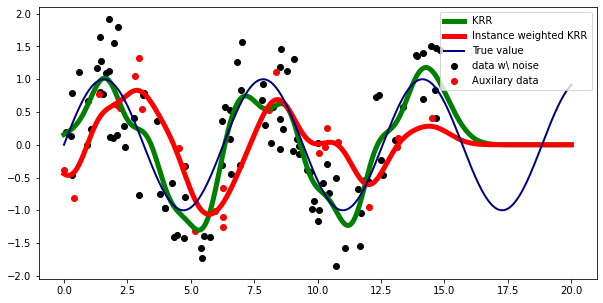

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from IW_KRR import InstanceKRR
    
#============================
rng = np.random.RandomState(0)
# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 2 * (0.5 - rng.rand(X.shape[0]))

rng = np.random.RandomState(1)
Xa = 15 * rng.rand(25, 1)
ya = np.sin(Xa-1).ravel()
ya += (0.5 - rng.rand(Xa.shape[0])) 

rng = np.random.RandomState(2)
Xt = 15 * rng.rand(50, 1)
yt = np.sin(Xt-1).ravel()

X_plot = np.linspace(0, 20, 10000)[:, None]

       
krr = InstanceKRR(lmbd = 0.5)
krr.fit(X,y)
yhat = krr.kRR_predict(X_plot)

krr.Solve_alpha(Xa,ya)
y_prd = krr.predict(X_plot)



# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, np.array(y), c='k', label='data w\ noise')
plt.plot(X_plot, np.array(yhat), c='g', lw = 5, label='KRR')

plt.scatter(Xa, ya, c = 'r', label = "Auxilary data")
plt.plot(X_plot, y_prd, c = 'r', lw = 5, label = "Instance weighted KRR")
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True value')
plt.legend()
plt.show()

In [13]:
import numpy as np
from adapt.instance_based import KLIEP

np.random.seed(0)
Xs = np.random.randn(50) * 0.1
Xs = np.concatenate((Xs, Xs + 1.))
Xt = np.random.randn(100) * 0.1
ys = np.array([-0.2 * x if x<0.5 else 1. for x in Xs])
yt = -0.2 * Xt

print(np.shape(Xs))
print(np.shape(ys))
print(np.shape(Xt))
print(np.shape(yt))
print(np.shape(Xs.reshape(-1,1)))

# kliep = KLIEP(sigmas = [0.1, 1, 10], random_state=0)
# kliep.fit_estimator(Xs.reshape(-1,1), ys)
# np.abs(kliep.predict(Xt.reshape(-1,1)).ravel() - yt).mean()
# kliep.fit(Xs.reshape(-1,1), ys, Xt.reshape(-1,1))
# np.abs(kliep.predict(Xt.reshape(-1,1)).ravel() - yt).mean()


(100,)
(100,)
(100,)
(100,)
(100, 1)


In [ ]:
import numpy as np
from adapt.instance_based import KMM

np.random.seed(0)
Xs = np.random.randn(50) * 0.1
Xs = np.concatenate((Xs, Xs + 1.))
Xt = np.random.randn(100) * 0.1
ys = np.array([-0.2 * x if x<0.5 else 1. for x in Xs])
yt = -0.2 * Xt

kmm = KMM(random_state=0)
kmm.fit_estimator(Xs.reshape(-1,1), ys)
np.abs(kmm.predict(Xt.reshape(-1,1)).ravel() - yt).mean()
kmm.fit(Xs.reshape(-1,1), ys, Xt.reshape(-1,1))
np.abs(kmm.predict(Xt.reshape(-1,1)).ravel() - yt).mean()


In [70]:
from scipy import stats

stats_StAd_rmse, pval_StAd_rmse = stats.ttest_ind(rmselist_stradaboost_concrete, rmselist_AdaTL_concrete)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_ind(rmselist_stradaboost_concrete, rmselist_GBRTL_concrete)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_ind(rmselist_stradaboost_concrete, rmselist_TwoTrAda_concrete)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_ind(r2scorelist_stradaboost_concrete, r2scorelist_AdaTL_concrete)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_ind(r2scorelist_stradaboost_concrete, r2scorelist_GBRTL_concrete)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_ind(r2scorelist_stradaboost_concrete, r2scorelist_TwoTrAda_concrete)
print(stats_StTr_r2, pval_StTr_r2)

0.06642893536867998 0.9477686137441723
1.803370278742918 0.08809539363436718
-0.6402691951701012 0.5300643497257027


0.543419163483719 0.5935081302926962
-1.064876041637561 0.30100883616380025
1.3293754446871224 0.20032802775973285


In [75]:
#### Dependent(paired) t-test
from scipy.stats import ttest_rel


stats_StAd_rmse, pval_StAd_rmse = stats.ttest_rel(rmselist_stradaboost_concrete, rmselist_AdaTL_concrete)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_rel(rmselist_stradaboost_concrete, rmselist_GBRTL_concrete)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_rel(rmselist_stradaboost_concrete, rmselist_TwoTrAda_concrete)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_rel(r2scorelist_stradaboost_concrete, r2scorelist_AdaTL_concrete)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_rel(r2scorelist_stradaboost_concrete, r2scorelist_GBRTL_concrete)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_rel(r2scorelist_stradaboost_concrete, r2scorelist_TwoTrAda_concrete)
print(stats_StTr_r2, pval_StTr_r2)

0.2664013235666798 0.7959330728063094
2.3414918477916933 0.04391284579630366
-0.745171561376906 0.47517702097403447


2.137024794237644 0.06131719383991011
-2.2358256739080944 0.052197892656036644
2.702336607860335 0.024300531692972208


In [16]:
################################### Housing ################################################################
## 'nox' found to be correlated at 0.4 :: [0.385 - 0.871] :: 50
#################################################################################################################################
HousingData_df = pd.read_csv('UCI_regression/BostonHousing/BostonHousing.csv') 
print("Housing Data")
print(HousingData_df.shape)

drop_col_housing = ['nox']
housing_tgt_df = HousingData_df.loc[(HousingData_df['nox'] <= 0.475)]
housing_tgt_df = housing_tgt_df.drop(drop_col_housing, axis = 1)
housing_tgt_df = housing_tgt_df.reset_index(drop=True)
print("Target Set: ",housing_tgt_df.shape)


housing_source1_df = HousingData_df.loc[(HousingData_df['nox'] > 0.475) & (HousingData_df['nox'] <= 0.600)]
housing_source1_df = housing_source1_df.drop(drop_col_housing, axis = 1)
housing_source1_df = housing_source1_df.reset_index(drop=True)
print("Source Set 1: ",housing_source1_df.shape)


housing_source2_df = HousingData_df.loc[(HousingData_df['nox'] > 0.600)]
housing_source2_df = housing_source2_df.drop(drop_col_housing, axis = 1)
housing_source2_df = housing_source2_df.reset_index(drop=True)
print("Source Set 2: ",housing_source2_df.shape)

################################# Standardization ############################
from sklearn.preprocessing import StandardScaler
housing_cols = housing_tgt_df.columns.difference(['medv'])

ss = StandardScaler()
housing_tgt_df[housing_cols] = ss.fit_transform(housing_tgt_df[housing_cols])
housing_source1_df[housing_cols] = ss.fit_transform(housing_source1_df[housing_cols])
housing_source2_df[housing_cols] = ss.fit_transform(housing_source2_df[housing_cols])


############################ Concatenating the source datasets ############################
housing_source_df = pd.concat([housing_source1_df, housing_source2_df], ignore_index = True)
housing_source_df = housing_source_df.reset_index(drop = True)

#################### Splitting into features and target ####################
target_housing = ['medv']

housing_source_df_y = housing_source_df[target_housing]
housing_source_df_X = housing_source_df.drop(target_housing, axis = 1)

features_housing = housing_source_df_X.columns

Housing Data
(506, 14)
Target Set:  (155, 13)
Source Set 1:  (186, 13)
Source Set 2:  (165, 13)


In [56]:
########################### TwoStagetrAdaBoostR2 Housing #######################################

from adapt.instance_based import TrAdaBoost, TrAdaBoostR2, TwoStageTrAdaBoostR2

def get_estimator(**kwargs):
    return DecisionTreeRegressor(max_depth = 6)

kwargs_TwoTrAda = {'steps': 30,
                    'fold': 10,
                  'learning_rate': 0.1}

print("Specification requirement complete!")

###########################################################################################################################

print("Two-Stage TrAdaboost.R2")
print("-------------------------------------------")

r2scorelist_TwoTrAda_housing = []
rmselist_TwoTrAda_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_X_df = pd.concat([housing_source_df_X, housing_train_df_X], ignore_index = True)
    housing_y_df = pd.concat([housing_source_df_y, housing_train_df_y], ignore_index = True)

    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()

    src_size_housing = len(housing_source_df_y)
    tgt_size_housing = len(housing_train_df_y)
    
    src_idx_housing = np.arange(start = 0, stop = (src_size_housing - 1), step=1)
    tgt_idx_housing = np.arange(start = src_size_housing, stop = ((src_size_housing + tgt_size_housing)-1), step = 1)


    model_TwoTrAda_housing = TwoStageTrAdaBoostR2(get_estimator = get_estimator, n_estimators = 100) #, cv = 10) 
    model_TwoTrAda_housing.fit(housing_np_train_X, housing_np_train_y_list, src_idx_housing, tgt_idx_housing)

    y_pred_TwoTrAda_housing = model_TwoTrAda_housing.predict(housing_np_test_X)

    mse_TwoTrAda_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_TwoTrAda_housing))
    rmselist_TwoTrAda_housing.append(mse_TwoTrAda_housing)
        
    r2_score_TwoTrAda_housing = pearsonr(housing_np_test_y_list, y_pred_TwoTrAda_housing)
    r2_score_TwoTrAda_housing = (r2_score_TwoTrAda_housing[0])**2
    r2scorelist_TwoTrAda_housing.append(r2_score_TwoTrAda_housing)

print("RMSE List TrAdaboost.R2:", rmselist_TwoTrAda_housing)
print("R^2 List TrAdaboost.R2:", r2scorelist_TwoTrAda_housing)

print("\n")


print("Mean, STDev of RMSE:", statistics.mean(rmselist_TwoTrAda_housing), statistics.stdev(rmselist_TwoTrAda_housing))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_TwoTrAda_housing), statistics.stdev(r2scorelist_TwoTrAda_housing))


print("-------------------------------------------")

Specification requirement complete!
Two-Stage TrAdaboost.R2
-------------------------------------------
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.
Binary search has not converged. Set value to the current best.


In [5]:
#################################### STrAdaBoost.R2 Housing ################################################################
from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2

n_estimators = 100
steps = 30
fold = 10
random_state = np.random.RandomState(1)

r2scorelist_stradaboost_housing = []
rmselist_stradaboost_housing = []

print("STrAdaboost.R2")
print("-------------------------------------------")

kf = KFold(n_splits = 10)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_X_df = pd.concat([housing_source_df_X, housing_train_df_X], ignore_index = True)
    housing_y_df = pd.concat([housing_source_df_y, housing_train_df_y], ignore_index = True)

    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()
    
    sample_size = [len(housing_source_df_X), len(housing_train_df_X)]


    model_stradaboost_housing = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth = 6),
                        n_estimators = n_estimators, sample_size = sample_size,
                        steps = steps, fold = fold, random_state = random_state)


    model_stradaboost_housing.fit(housing_np_train_X, housing_np_train_y_list)
    y_pred_stradaboost_housing = model_stradaboost_housing.predict(housing_np_test_X)


    mse_stradaboost_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_stradaboost_housing))
    rmselist_stradaboost_housing.append(mse_stradaboost_housing)
        
    r2_score_stradaboost_housing = pearsonr(housing_np_test_y_list, y_pred_stradaboost_housing)
    r2_score_stradaboost_housing = (r2_score_stradaboost_housing[0])**2
    r2scorelist_stradaboost_housing.append(r2_score_stradaboost_housing)

print("RMSE of STrAdaboost.R2:", rmselist_stradaboost_housing)
print("R^2 of STrAdaboost.R2:", r2scorelist_stradaboost_housing)

print("\n")


print("Mean, STDev of RMSE:", statistics.mean(rmselist_stradaboost_housing), statistics.stdev(rmselist_stradaboost_housing))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_stradaboost_housing), statistics.stdev(r2scorelist_stradaboost_housing))


STrAdaboost.R2
-------------------------------------------
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
RMSE of STrAdaboost.R2: [2.643518097047088, 2.0446110978325023, 1.3264814902392026, 3.1412323088120258, 6.055358754659789, 2.107677222789961, 7.369388206228197, 2.616042210901775, 3.104185474452117, 1.7473932471670033]
R^2 of STrAdaboost.R2: [0.929416103939321, 0.9273003801642, 0.7701803567088483, 0.92194781914337, 0.7690628160942707, 0.7433110429384416, 0.5842195424875491, 0.953111794488, 0.6663405802785274, 0.9329793790565483]


Mean, STDev of RMSE: 3.215588811012966 1.9535149217076844
Mean, STDev of R^2: 0.8197869815299077 0.13103124329668592


In [58]:
########################### AdaBoostR2 Transfer Learning Housing #####################################################
from sklearn.ensemble import AdaBoostRegressor

print("Adaboost.R2 Transfer Learning")
print("-------------------------------------------")

r2scorelist_AdaTL_housing = []
rmselist_AdaTL_housing = []

kf = KFold(n_splits = 10)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_X_df = pd.concat([housing_source_df_X, housing_train_df_X], ignore_index = True)
    housing_y_df = pd.concat([housing_source_df_y, housing_train_df_y], ignore_index = True)

    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()


    model_AdaTL_housing = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_AdaTL_housing.fit(housing_np_train_X, housing_np_train_y_list)

    y_pred_AdaTL_housing = model_AdaTL_housing.predict(housing_np_test_X)

    mse_AdaTL_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_AdaTL_housing))
    rmselist_AdaTL_housing.append(mse_AdaTL_housing)
        
    r2_score_AdaTL_housing = pearsonr(housing_np_test_y_list, y_pred_AdaTL_housing)
    r2_score_AdaTL_housing = (r2_score_AdaTL_housing[0])**2
    r2scorelist_AdaTL_housing.append(r2_score_AdaTL_housing)

print("RMSE List of Adaboost.R2:", rmselist_AdaTL_housing)
print("R^2 List of AdaboostR2:", r2scorelist_AdaTL_housing)

print("\n")

print("Mean, Stdev of RMSE:", statistics.mean(rmselist_AdaTL_housing), statistics.stdev(rmselist_AdaTL_housing))
print("Mean, Stdev of R^2:", statistics.mean(r2scorelist_AdaTL_housing), statistics.stdev(r2scorelist_AdaTL_housing))


print("-------------------------------------------")

Adaboost.R2 Transfer Learning
-------------------------------------------
RMSE List of Adaboost.R2: [3.08093208818374, 2.1387404887311665, 1.4568218936233506, 3.1149603921322124, 5.649134873022684, 2.019204145681526, 7.443647763089025, 2.773863640063722, 2.891185148078168, 1.9126907919331761]
R^2 List of AdaboostR2: [0.8876367480075871, 0.9105254644040658, 0.7649082994209835, 0.9192629947440659, 0.8606479246265066, 0.8178371107386858, 0.5822544847648489, 0.9477779258828463, 0.7337170468465634, 0.9510545290145113]


Mean, Stdev of RMSE: 3.248118122453877 1.8707814067465698
Mean, Stdev of R^2: 0.8375622528450665 0.11628537575902734
-------------------------------------------


In [12]:
################################## Gradient Boosting Regression Transfer Learning Housing #######################################
from sklearn.ensemble import GradientBoostingRegressor

print("Gradient Boosting Regression Transfer Learning")
print("-------------------------------------------")

r2scorelist_GBRTL_housing = []
rmselist_GBRTL_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_X_df = pd.concat([housing_source_df_X, housing_train_df_X], ignore_index = True)
    housing_y_df = pd.concat([housing_source_df_y, housing_train_df_y], ignore_index = True)

    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()

    model_GBRTL_housing = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100) #, subsample=0.5)
    model_GBRTL_housing.fit(housing_np_train_X, housing_np_train_y_list)

    y_pred_GBRTL_housing = model_GBRTL_housing.predict(housing_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_GBRTL_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_GBRTL_housing))
    rmselist_GBRTL_housing.append(mse_GBRTL_housing)
        
    r2_score_GBRTL_housing = pearsonr(housing_np_test_y_list, y_pred_GBRTL_housing)
    r2_score_GBRTL_housing = (r2_score_GBRTL_housing[0])**2
    r2scorelist_GBRTL_housing.append(r2_score_GBRTL_housing)

print("RMSE List of GBRTL:", rmselist_GBRTL_housing)
print("R^2 List of GBRTL:", r2scorelist_GBRTL_housing)

print("\n")


print("Mean, Stdev of RMSE:", statistics.mean(rmselist_GBRTL_housing), statistics.stdev(rmselist_GBRTL_housing))
print("Mean, Stdev of R^2:", statistics.mean(r2scorelist_GBRTL_housing), statistics.stdev(r2scorelist_GBRTL_housing))


print("-------------------------------------------")

Gradient Boosting Regression Transfer Learning
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434

RMSE List of GBRTL: [3.2002238942191252, 2.410123507159773, 2.0796830343326946, 1.9183806855293195, 1.2964843885771486, 1.3847024597606314, 1.9859445723197668, 3.239165729889791, 4.849700620126591, 6.893720392358554, 1.2454158407456728, 6.811744835440854, 4.150265760834754, 4.480156585180506, 2.4656947427360456, 2.542496429628167, 2.634456217477316, 1.4216845280443506, 1.615131473191891, 1.8397452247446722]
R^2 List of GBRTL: [0.6457829656897999, 0.835314875976937, 0.8661669337923578, 0.8723578018974302, 0.763981693575525, 0.7707173457901498, 0.2064254041578625, 0.9403030638965592, 0.8431105233430062, 0.6434496456022448, 0.8169108464325716, 0.17391533264923068, 0.8719305225167314, 0.7751525210238152, 0.9558589263767592, 0.769019760499597, 0.7074283921909684, 0.9485767404177595, 0.9835511091717741, 0.8700048641978019]


Mean, Stdev of RMSE: 2.9232460461148815 1.7009548396131993
Mean, Stdev of R^2: 0.7629979634599441 0.21768461179218776
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [31]:
###################################### Regular AdaBoostR2 Housing ##############################################################
from sklearn.ensemble import AdaBoostRegressor

print("Regular Adaboost.R2")
print("-------------------------------------------")

r2scorelist_Ada_housing = []
rmselist_Ada_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()

    model_Ada_housing = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_Ada_housing.fit(housing_train_df_X, housing_train_df_y)

    y_pred_Ada_housing = model_Ada_housing.predict(housing_np_test_X)

    mse_Ada_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_Ada_housing))
    rmselist_Ada_housing.append(mse_Ada_housing)
        
    r2_score_Ada_housing = pearsonr(housing_np_test_y_list, y_pred_Ada_housing)
    r2_score_Ada_housing = (r2_score_Ada_housing[0])**2
    r2scorelist_Ada_housing.append(r2_score_Ada_housing)

print("RMSE List of Adaboost.R2:", rmselist_Ada_housing)
print("R^2 List of AdaboostR2:", r2scorelist_Ada_housing)

print("\n")

print("RMSE of Adaboost.R2:", statistics.mean(rmselist_Ada_housing), statistics.stdev(rmselist_Ada_housing))
print("R^2 of AdaboostR2:", statistics.mean(r2scorelist_Ada_housing), statistics.stdev(r2scorelist_Ada_housing))

print("-------------------------------------------")

Regular Adaboost.R2
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validat

RMSE List of Adaboost.R2: [2.76372249076749, 2.4995357931053293, 1.8437763872588113, 1.413670654683692, 1.2381669528361698, 1.2195771486617735, 1.6621481765708483, 2.9571963471463487, 3.871185604343538, 2.4522453964172244, 1.9218766496419573, 2.605526831930049, 5.147678447880924, 3.5264182459914135, 1.3381775216605296, 2.724961057189721, 3.078334422195404, 2.3955474482371595, 2.5230684077432883, 3.080083551227089]
R^2 List of AdaboostR2: [0.6884043235888353, 0.7859726919188234, 0.8931793035010221, 0.9503064627037221, 0.6928970707225619, 0.8611049133716916, 0.5851320648229225, 0.8917538368879923, 0.7583574052312779, 0.9323758255103389, 0.7655502629689449, 0.9258575205492496, 0.6516808417877064, 0.8962925538110625, 0.99468029689039, 0.7399570121167331, 0.8321595951694181, 0.8497331641697172, 0.9921954085796764, 0.7442760209179091]


RMSE of Adaboost.R2: 2.513144876774438 0.9785580695019643
R^2 of AdaboostR2: 0.8215933287609998 0.11630355442197252
-----------------------------------------

/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [32]:
############################# Regular Gradient Boosting Regression Housing #######################################
from sklearn.ensemble import GradientBoostingRegressor


print("Regular Gradient Boosting Regression")
print("-------------------------------------------")

r2scorelist_GBR_housing = []
rmselist_GBR_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()


    model_GBR_housing = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100, subsample=0.5)
    model_GBR_housing.fit(housing_train_df_X, housing_train_df_y)

    y_pred_GBR_housing = model_GBR_housing.predict(housing_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_GBR_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_GBR_housing))
    rmselist_GBR_housing.append(mse_GBR_housing)
        
    r2_score_GBR_housing = pearsonr(housing_np_test_y_list, y_pred_GBR_housing)
    r2_score_GBR_housing = (r2_score_GBR_housing[0])**2
    r2scorelist_GBR_housing.append(r2_score_GBR_housing)

print("RMSE List of GBR:", rmselist_GBR_housing)
print("R^2 List of GBR:", r2scorelist_GBR_housing)

print("\n")

print("RMSE of GBR:", statistics.mean(rmselist_GBR_housing), statistics.stdev(rmselist_GBR_housing))
print("R^2 of GBR:", statistics.mean(r2scorelist_GBR_housing), statistics.stdev(r2scorelist_GBR_housing))

print("-------------------------------------------")

Regular Gradient Boosting Regression
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

RMSE List of GBR: [2.9609357147171944, 1.9799132947974447, 1.2849348954085653, 2.1467431926029605, 1.199058300816874, 0.9313947146593611, 1.3073712198748983, 2.5184964175042164, 2.8320290986676167, 2.107307803616224, 2.4253043626454494, 2.0899431828354986, 3.1417774201516755, 3.0574756936240832, 1.0373030292774024, 2.70973694467034, 3.595336392697529, 2.1896197482170088, 2.3567945849649763, 2.5837254573388075]
R^2 List of GBR: [0.6930207798390742, 0.9032760963097143, 0.9557441467767738, 0.9558693605022983, 0.7557580047652949, 0.9404464038923338, 0.657312647994583, 0.9442469012525332, 0.836291214431168, 0.9572984272907852, 0.7647663764406228, 0.9086396654977117, 0.8617034029690337, 0.9562458448049314, 0.9915463337565664, 0.7515993562441233, 0.6507092378911823, 0.8712719921188293, 0.9892377451211978, 0.8613123109717782]


RMSE of GBR: 2.222760073454406 0.753604835705814
R^2 of GBR: 0.8603148124435268 0.11098789523865255
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
################################### Kernel Mean Matching Housing #######################################################
from adapt.instance_based import KMM


print("Kernel Mean Matching")
print("-------------------------------------------")

r2scorelist_KMM_housing = []
rmselist_KMM_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_np_train_X = housing_train_df_X.to_numpy()
    housing_np_train_y = housing_train_df_y.to_numpy()

    housing_np_source_X = housing_source_df_X.to_numpy()
    housing_np_source_y = housing_source_df_y.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()
    
    src_size_housing = len(housing_source_df_y)
    tgt_size_housing = len(housing_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_housing - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_housing - 1), step=1)

    model_KMM_housing = KMM(DecisionTreeRegressor(max_depth = 6))
    model_KMM_housing.fit(housing_np_source_X[src_idx], housing_np_source_y[src_idx], housing_np_train_X[tgt_idx], housing_np_train_y[tgt_idx])

    y_pred_KMM_housing = model_KMM_housing.predict(housing_test_df_X) 

    mse_KMM_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_KMM_housing))
    rmselist_KMM_housing.append(mse_KMM_housing)
        
    r2_score_KMM_housing = pearsonr(housing_np_test_y_list, y_pred_KMM_housing)
    r2_score_KMM_housing = (r2_score_KMM_housing[0])**2
    r2scorelist_KMM_housing.append(r2_score_KMM_housing)

print("RMSE List of KMM:", rmselist_KMM_housing)
print("R^2 List of KMM:", r2scorelist_KMM_housing)

print("\n")

print("RMSE of KMM:", statistics.mean(rmselist_KMM_housing), statistics.stdev(rmselist_KMM_housing))
print("R^2 of KMM:", statistics.mean(r2scorelist_KMM_housing), statistics.stdev(r2scorelist_KMM_housing))


print("-------------------------------------------")

Kernel Mean Matching
-------------------------------------------
Fit weights...
     pcost       dcost       gap    pres   dres
 0: -3.3595e+03 -3.0574e+06  5e+07  2e-01  6e-15
 1: -3.7469e+03 -7.2771e+05  1e+06  2e-03  3e-13
 2: -1.5031e+03 -1.0681e+05  1e+05  1e-05  5e-13
 3: -4.1540e+03 -4.2551e+04  4e+04  5e-06  1e-13
 4: -1.1889e+04 -5.6735e+04  4e+04  7e-07  2e-14
 5: -1.2223e+04 -2.2167e+04  1e+04  2e-07  5e-15
 6: -1.2391e+04 -1.6341e+04  4e+03  2e-16  5e-16
 7: -1.2539e+04 -1.3650e+04  1e+03  2e-16  5e-16
 8: -1.2616e+04 -1.3194e+04  6e+02  2e-16  5e-16
 9: -1.2652e+04 -1.2816e+04  2e+02  2e-16  5e-16
10: -1.2678e+04 -1.2717e+04  4e+01  2e-16  5e-16
11: -1.2685e+04 -1.2698e+04  1e+01  2e-16  5e-16
12: -1.2688e+04 -1.2690e+04  2e+00  2e-16  6e-16
13: -1.2689e+04 -1.2689e+04  1e-01  2e-16  5e-16
14: -1.2689e+04 -1.2689e+04  4e-03  2e-16  5e-16
Optimal solution found.
Fit Estimator...
Fit weights...
     pcost       dcost       gap    pres   dres
 0: -3.9138e+03 -3.0574e+06  5e+0

In [19]:
######################### KLIEP Housing #######################################

from adapt.instance_based import KLIEP

print("KLIEP")

r2scorelist_KLIEP_housing = []
rmselist_KLIEP_housing = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
  
    housing_np_train_X = housing_train_df_X.to_numpy()
    housing_np_train_y = housing_train_df_y.to_numpy()

    housing_np_source_X = housing_source_df_X.to_numpy()
    housing_np_source_y = housing_source_df_y.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()
    
    src_size_housing = len(housing_source_df_y)
    tgt_size_housing = len(housing_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_housing - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_housing - 1), step=1)
    
    model_KLIEP_housing = KLIEP(DecisionTreeRegressor(max_depth = 6), sigmas = [0.1, 1, 10])
    model_KLIEP_housing.fit(housing_np_source_X[src_idx], housing_np_source_y[src_idx], housing_np_train_X[tgt_idx], housing_np_train_y[tgt_idx])

    y_pred_KLIEP_housing = model_KLIEP_housing.predict(housing_test_df_X) 

    mse_KLIEP_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_KLIEP_housing))
    rmselist_KLIEP_housing.append(mse_KLIEP_housing)

    r2_score_KLIEP_housing = pearsonr(housing_np_test_y_list, y_pred_KLIEP_housing)
    r2_score_KLIEP_housing = (r2_score_KLIEP_housing[0])**2
    r2scorelist_KLIEP_housing.append(r2_score_KLIEP_housing)

print("RMSE List of KLIEP:", rmselist_KLIEP_housing)
print("R^2 List of KLIEP:", r2scorelist_KLIEP_housing)

print("\n")

print("RMSE of KLIEP:", statistics.mean(rmselist_KLIEP_housing), statistics.stdev(rmselist_KLIEP_housing))
print("R^2 of KLIEP:", statistics.mean(r2scorelist_KLIEP_housing), statistics.stdev(r2scorelist_KLIEP_housing))

print("-------------------------------------------")

KLIEP
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = -0.123 (0.106)
Parameter sigma = 1.0000 -- J-score = -2.274 (0.646)
Parameter sigma = 10.0000 -- J-score = -21.657 (1.667)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = -0.086 (0.056)
Parameter sigma = 1.0000 -- J-score = -2.214 (0.428)
Parameter sigma = 10.0000 -- J-score = -23.337 (1.310)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = -0.116 (0.025)
Parameter sigma = 1.0000 -- J-score = -2.112 (0.388)
Parameter sigma = 10.0000 -- J-score = -22.534 (1.375)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = -0.110 (0.091)
Parameter sigma = 1.0000 -- J-score = -2.290 (0.799)
Parameter sigma = 10.0000 -- J-score = -22.711 (2.165)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = -0.119 (0.107)
Parameter sigm

In [33]:
#################################### Instance_KRR Housing ################################################################
from IW_KRR import InstanceKRR

n_estimators = 100
steps = 30
fold = 20

r2scorelist_IWKRR_housing = []
rmselist_IWKRR_housing = []

print("IWKRR")
print("-------------------------------------------")


kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(housing_tgt_df):
        
    housing_train_df_X = housing_tgt_df.iloc[train_idx].loc[:, features_housing]
    housing_test_df_X = housing_tgt_df.iloc[test_idx][features_housing]
    housing_train_df_y = housing_tgt_df.iloc[train_idx].loc[:,target_housing]
    housing_test_df_y = housing_tgt_df.loc[test_idx][target_housing]
    
    housing_np_tgt_X = housing_train_df_X.to_numpy()
    housing_np_tgt_y = housing_train_df_y.to_numpy()

        
    housing_X_df = pd.concat([housing_source_df_X, housing_train_df_X], ignore_index=True)
    housing_y_df = pd.concat([housing_source_df_y, housing_train_df_y], ignore_index=True)

    housing_np_train_X = housing_X_df.to_numpy()
    housing_np_train_y = housing_y_df.to_numpy()

    housing_np_test_X = housing_test_df_X.to_numpy()
    housing_np_test_y = housing_test_df_y.to_numpy()

    housing_np_train_y_list = housing_np_train_y.ravel()
    housing_np_test_y_list = housing_np_test_y.ravel()
    
    sample_size = [len(housing_source_df_X), len(housing_train_df_X)]


    model_IWKRR_housing = InstanceKRR(lmbd = 0.5, kernel = 'rbf',gamma = None, degree = 3, coef0 = 1,kernel_params = None)
    model_IWKRR_housing.fit(housing_np_train_X, housing_np_train_y_list)
    model_IWKRR_housing.Solve_alpha(housing_np_tgt_X,housing_np_tgt_y)
    
    y_pred_IWKRR_housing = model_IWKRR_housing.predict(housing_np_test_X)
    y_pred_IWKRR_housing = [item for sublist in y_pred_IWKRR_housing for item in sublist]

    mse_IWKRR_housing = sqrt(mean_squared_error(housing_np_test_y, y_pred_IWKRR_housing))
    rmselist_IWKRR_housing.append(mse_IWKRR_housing)
        
    r2_score_IWKRR_housing = pearsonr(housing_np_test_y_list, y_pred_IWKRR_housing)
    r2_score_IWKRR_housing = (r2_score_IWKRR_housing[0])**2
    r2scorelist_IWKRR_housing.append(r2_score_IWKRR_housing)


print("RMSE List of IWKRR:", rmselist_IWKRR_housing)
print("R^2 List of IWKRR:", r2scorelist_IWKRR_housing)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_IWKRR_housing), statistics.stdev(rmselist_IWKRR_housing))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_IWKRR_housing), statistics.stdev(r2scorelist_IWKRR_housing))


IWKRR
-------------------------------------------
     pcost       dcost       gap    pres   dres
 0: -5.5964e+04 -5.5653e+04  1e+03  5e+01  2e-03
 1: -5.5949e+04 -5.5423e+04  7e+02  3e+01  1e-03
 2: -5.2127e+04 -5.3023e+04  8e+03  3e+01  1e-03
 3: -4.9215e+04 -4.0811e+04  1e+04  2e+01  9e-04
 4: -4.5301e+04 -2.8722e+04  1e+04  2e+01  8e-04
 5: -4.1016e+04 -2.1029e+04  2e+04  2e+01  7e-04
 6: -2.9585e+04 -9.9420e+03  2e+04  1e+01  5e-04
 7:  4.6381e+03 -1.8855e+03  1e+04  8e-01  3e-05
 8:  4.2241e+02 -2.2934e+02  7e+02  8e-03  3e-07
 9:  4.4409e+01 -3.0378e+01  8e+01  7e-05  3e-09
10:  5.5841e+00 -4.0153e+00  1e+01  1e-07  5e-12
11:  7.3565e-01 -5.2935e-01  1e+00  5e-16  6e-16
12:  9.7231e-02 -6.9781e-02  2e-01  2e-16  5e-16
13:  1.2713e-02 -9.2530e-03  2e-02  6e-17  6e-16
14:  1.6300e-03 -1.2470e-03  3e-03  3e-17  5e-16
15:  2.1859e-04 -1.6920e-04  4e-04  8e-18  5e-16
16:  2.9769e-05 -2.2952e-05  5e-05  3e-18  5e-16
17:  4.0486e-06 -3.1094e-06  7e-06  1e-18  5e-16
18:  5.5026e-07 -4.2

In [71]:
from scipy import stats

stats_StAd_rmse, pval_StAd_rmse = stats.ttest_ind(rmselist_stradaboost_housing, rmselist_AdaTL_housing)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_ind(rmselist_stradaboost_housing, rmselist_GBRTL_housing)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_ind(rmselist_stradaboost_housing, rmselist_TwoTrAda_housing)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_ind(r2scorelist_stradaboost_housing, r2scorelist_AdaTL_housing)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_ind(r2scorelist_stradaboost_housing, r2scorelist_GBRTL_housing)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_ind(r2scorelist_stradaboost_housing, r2scorelist_TwoTrAda_housing)
print(stats_StTr_r2, pval_StTr_r2)

-0.11320807483759392 0.9111186613495608
0.6142376111006888 0.5467442730953394
-0.7877168016462025 0.4411126634078205


-0.3577646135896259 0.7246802877655424
-0.6235793100410496 0.5407261834520463
1.9792126669704677 0.06329652761434805


In [74]:
#### Dependent(paired) t-test
from scipy.stats import ttest_rel


stats_StAd_rmse, pval_StAd_rmse = stats.ttest_rel(rmselist_stradaboost_housing, rmselist_AdaTL_housing)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_rel(rmselist_stradaboost_housing, rmselist_GBRTL_housing)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_rel(rmselist_stradaboost_housing, rmselist_TwoTrAda_housing)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_rel(r2scorelist_stradaboost_housing, r2scorelist_AdaTL_housing)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_rel(r2scorelist_stradaboost_housing, r2scorelist_GBRTL_housing)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_rel(r2scorelist_stradaboost_housing, r2scorelist_TwoTrAda_housing)
print(stats_StTr_r2, pval_StTr_r2)

-0.7996854083202125 0.44448619214735663
1.7669802852038805 0.11103400281068965
-1.7148762764672583 0.12050921388855486


-1.1582914763418435 0.2765565179145322
-0.9686871369054251 0.35801096964238777
2.7169621385318274 0.023725511885053154


In [21]:
######################################################## Automobile ################################################################
## horsepower column has correlation 0.4 :: [46 - 230] :: 30
#################################################################################################################################
dropcol_initial_auto = ['name']
AutoData_df = pd.read_csv('UCI_regression/MPG/Auto.csv') ## horsepower column has correlation 0.4 :: [46 - 230] :: 30
AutoData_df = AutoData_df.drop(dropcol_initial_auto, axis = 1)
print("The shape of the Input data is: ", AutoData_df.shape)

drop_col_auto = ['horsepower']

auto_tgt_df = AutoData_df.loc[(AutoData_df['horsepower'] <= 80)]
auto_tgt_df = auto_tgt_df.drop(drop_col_auto, axis = 1)
auto_tgt_df = auto_tgt_df.reset_index(drop=True)
print("Target Set: ",auto_tgt_df.shape)

auto_source1_df = AutoData_df.loc[(AutoData_df['horsepower'] > 80) & (AutoData_df['horsepower'] <= 110)]
auto_source1_df = auto_source1_df.drop(drop_col_auto, axis = 1)
auto_source1_df = auto_source1_df.reset_index(drop=True)
print("Source Set 1: ",auto_source1_df.shape)

auto_source2_df = AutoData_df.loc[(AutoData_df['horsepower'] > 110)]
auto_source2_df = auto_source2_df.drop(drop_col_auto, axis = 1)
auto_source2_df = auto_source2_df.reset_index(drop=True)
print("Source Set 2: ",auto_source2_df.shape)

################################# Standardization ############################
from sklearn.preprocessing import StandardScaler
auto_cols = auto_tgt_df.columns.difference(['medv'])

ss = StandardScaler()
auto_tgt_df[auto_cols] = ss.fit_transform(auto_tgt_df[auto_cols])
auto_source1_df[auto_cols] = ss.fit_transform(auto_source1_df[auto_cols])
auto_source2_df[auto_cols] = ss.fit_transform(auto_source2_df[auto_cols])

## Concatenating the source datasets
auto_source_df = pd.concat([auto_source1_df, auto_source2_df], ignore_index = True)
auto_source_df = auto_source_df.reset_index(drop = True)

#################### Splitting into features and target ####################
target_auto = ['mpg']

auto_source_df_y = auto_source_df[target_auto]
auto_source_df_X = auto_source_df.drop(target_auto, axis = 1)

features_auto = auto_source_df_X.columns

The shape of the Input data is:  (392, 8)
Target Set:  (119, 7)
Source Set 1:  (157, 7)
Source Set 2:  (116, 7)


In [63]:
########################### TwoStage-TrAdaBoostR2 Auto #######################################

from adapt.instance_based import TrAdaBoost, TrAdaBoostR2, TwoStageTrAdaBoostR2


def get_estimator(**kwargs):
    return DecisionTreeRegressor(max_depth = 6)

kwargs_TwoTrAda = {'steps': 30,
                    'fold': 10,
                  'learning_rate': 0.1}

###########################################################################################################################

print("Two-Stage TrAdaboost.R2")
print("-------------------------------------------")

r2scorelist_TwoTrAda_auto = []
rmselist_TwoTrAda_auto = []

kf = KFold(n_splits = 20)


for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_X_df = pd.concat([auto_source_df_X, auto_train_df_X], ignore_index=True)
    auto_y_df = pd.concat([auto_source_df_y, auto_train_df_y], ignore_index=True)

    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()

    src_size_auto = len(auto_source_df_y)
    tgt_size_auto = len(auto_train_df_y)
    
    src_idx_auto = np.arange(start=0, stop=(src_size_auto - 1), step=1)
    tgt_idx_auto = np.arange(start=src_size_auto, stop=((src_size_auto + tgt_size_auto)-1), step=1)


    model_TwoTrAda_auto = TwoStageTrAdaBoostR2(get_estimator = get_estimator, n_estimators = 100) #, cv = 10) 
    model_TwoTrAda_auto.fit(auto_np_train_X, auto_np_train_y_list, src_idx_auto, tgt_idx_auto)

    y_pred_TwoTrAda_auto = model_TwoTrAda_auto.predict(auto_np_test_X)

    mse_TwoTrAda_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_TwoTrAda_auto))
    rmselist_TwoTrAda_auto.append(mse_TwoTrAda_auto)
        
    r2_score_TwoTrAda_auto = pearsonr(auto_np_test_y_list, y_pred_TwoTrAda_auto)
    r2_score_TwoTrAda_auto = (r2_score_TwoTrAda_auto[0])**2
    r2scorelist_TwoTrAda_auto.append(r2_score_TwoTrAda_auto)


print("RMSE List of TrAdaboost.R2:", rmselist_TwoTrAda_auto)
print("R^2 List of TrAdaboost.R2:", r2scorelist_TwoTrAda_auto)

print("\n")

print("Mean, Stdev of RMSE:", statistics.mean(rmselist_TwoTrAda_auto), statistics.stdev(rmselist_TwoTrAda_auto))
print("Mean, Stdev of R^2:", statistics.mean(r2scorelist_TwoTrAda_auto), statistics.stdev(r2scorelist_TwoTrAda_auto))


print("-------------------------------------------")

RMSE List of TrAdaboost.R2: [0.4243043188387373, 0.517195423770981, 0.6519664186500195, 0.31278770618508533, 0.9106076952664754, 0.7497905408530762, 0.7627149189699569, 1.121907562688717, 0.5554295196299659, 0.7564328904509023]
R^2 List of TrAdaboost.R2: [0.6554314111862946, 0.692713134420256, 0.6919383600901492, 0.8320631128745823, 0.12787056044070017, 0.6518615219543017, 0.3360064656178717, 0.0010568568496436836, 0.015296602690126363, 0.08681036876262815]


Mean, Stdev of RMSE: 0.6763136995303917 0.23779424942091276
Mean, Stdev of R^2: 0.4091048394886554 0.32809681066253876
-------------------------------------------


In [7]:
#################################### STrAdaBoost.R2 Active Sampling Auto ################################################################
from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2

n_estimators = 100
steps = 30
fold = 10
random_state = np.random.RandomState(1)

r2scorelist_stradaboost_auto = []
rmselist_stradaboost_auto = []

print("Two-Stage STrAdaboost.R2")
print("-------------------------------------------")

kf = KFold(n_splits = 20)


for train_idx, test_idx in kf.split(auto_tgt_df):

    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]

    auto_X_df = pd.concat([auto_source_df_X, auto_train_df_X], ignore_index=True)
    auto_y_df = pd.concat([auto_source_df_y, auto_train_df_y], ignore_index=True)

    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()

    sample_size = [len(auto_source_df_X), len(auto_train_df_X)]


    model_stradaboost_auto = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth = 6),
                        n_estimators = n_estimators, sample_size = sample_size,
                        steps = steps, fold = fold, random_state = random_state)


    model_stradaboost_auto.fit(auto_np_train_X, auto_np_train_y_list)
    y_pred_stradaboost_auto = model_stradaboost_auto.predict(auto_np_test_X)


    mse_stradaboost_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_stradaboost_auto))
    rmselist_stradaboost_auto.append(mse_stradaboost_auto)

    r2_score_stradaboost_auto = pearsonr(auto_np_test_y_list, y_pred_stradaboost_auto)
    r2_score_stradaboost_auto = (r2_score_stradaboost_auto[0])**2
    r2scorelist_stradaboost_auto.append(r2_score_stradaboost_auto)


print("RMSE List of STrAdaboostR2:", rmselist_stradaboost_auto)
print("R^2 List of STrAdaboostR2:", r2scorelist_stradaboost_auto)

print("\n")

print("Mean, Stdev of RMSE:", statistics.mean(rmselist_stradaboost_auto), statistics.stdev(rmselist_stradaboost_auto))
print("Mean, Stdev of R^2:", statistics.mean(r2scorelist_stradaboost_auto), statistics.stdev(r2scorelist_stradaboost_auto))


print("-------------------------------------------")

Two-Stage STrAdaboost.R2
-------------------------------------------
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
Inside Updated Sampling TrAdaBoost.R2
RMSE List of STrAdaboostR2: [0.5582854151910699, 0.4436385935251228, 0.6053261547923454, 0.45073472858445096, 0.9299787194313835, 0.4053955864341286, 0.9734016786434954, 1.0113509646269083, 0.30055525875003813, 0.506236630402056]
R^2 List of STrAdaboostR2: [0.8264871364575337, 0.5535348790808966, 0.8478100005728715, 0.8284247951938495, 0.04558676968026823, 0.5657909125356079, 0.3070933003253697, 0.05651190865072696, 0.5732291139313791, 0.5207809014653438]


Mean, Stdev of RMSE: 0.6184903730381 0.2579691048590702
Mean, Stdev of R^2: 0.51252497178

In [65]:
########################### AdaBoostR2 Transfer Learning Auto #####################################################

from sklearn.ensemble import AdaBoostRegressor


print("Adaboost.R2 Transfer Learning")
print("-------------------------------------------")

r2scorelist_AdaTL_auto = []
rmselist_AdaTL_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_X_df = pd.concat([auto_source_df_X, auto_train_df_X], ignore_index = True)
    auto_y_df = pd.concat([auto_source_df_y, auto_train_df_y], ignore_index = True)

    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()


    model_AdaTL_auto = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_AdaTL_auto.fit(auto_np_train_X, auto_np_train_y_list)

    y_pred_AdaTL_auto = model_AdaTL_auto.predict(auto_np_test_X)

    mse_AdaTL_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_AdaTL_auto))
    rmselist_AdaTL_auto.append(mse_AdaTL_auto)
        
    r2_score_AdaTL_auto = pearsonr(auto_np_test_y_list, y_pred_AdaTL_auto)
    r2_score_AdaTL_auto = (r2_score_AdaTL_auto[0])**2
    r2scorelist_AdaTL_auto.append(r2_score_AdaTL_auto)

print("RMSE List of TL Adaboost.R2:", rmselist_AdaTL_auto)
print("R^2 List of TL Adaboost.R2:", r2scorelist_AdaTL_auto)

print("\n")


print("Mean, Stdev of RMSE:", statistics.mean(rmselist_AdaTL_auto), statistics.stdev(rmselist_AdaTL_auto))
print("Mean, Stdev of R^2:", statistics.mean(r2scorelist_AdaTL_auto), statistics.stdev(r2scorelist_AdaTL_auto))


print("-------------------------------------------")

Adaboost.R2 Transfer Learning
-------------------------------------------
RMSE List of TL Adaboost.R2: [0.5135340662862089, 0.45359876137148253, 0.5592345186096519, 0.3134179943083618, 0.8944293662623398, 0.397764732639691, 0.9622384274167044, 0.9788976778450925, 0.30320142517921744, 0.48423314234349674]
R^2 List of TL Adaboost.R2: [0.8274059627537894, 0.6488743694737944, 0.8217234574146408, 0.8640250561996212, 0.10495483046155453, 0.5214274608220493, 0.4256364319788598, 0.0587711740828452, 0.5886460061348928, 0.5412400077405197]


Mean, Stdev of RMSE: 0.5860550112262247 0.2613246951608417
Mean, Stdev of R^2: 0.5402704757062567 0.2819481525530993
-------------------------------------------


In [66]:
######################### Gradient Boosting Regression Transfer Learning Auto #######################################
from sklearn.ensemble import GradientBoostingRegressor

print("Gradient Boosting Regression Transfer Learning")
print("-------------------------------------------")

r2scorelist_GBRTL_auto = []
rmselist_GBRTL_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_X_df = pd.concat([auto_source_df_X, auto_train_df_X], ignore_index = True)
    auto_y_df = pd.concat([auto_source_df_y, auto_train_df_y], ignore_index = True)

    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()


    model_GBRTL_auto = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100) #, subsample=0.5)
    model_GBRTL_auto.fit(auto_np_train_X, auto_np_train_y_list)

    y_pred_GBRTL_auto = model_GBRTL_auto.predict(auto_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_GBRTL_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_GBRTL_auto))
    rmselist_GBRTL_auto.append(mse_GBRTL_auto)
        
    r2_score_GBRTL_auto = pearsonr(auto_np_test_y_list, y_pred_GBRTL_auto)
    r2_score_GBRTL_auto = (r2_score_GBRTL_auto[0])**2
    r2scorelist_GBRTL_auto.append(r2_score_GBRTL_auto)

print("RMSE List of GBRTL:", rmselist_GBRTL_auto)
print("R^2 List of GBRTL:", r2scorelist_GBRTL_auto)

print("\n")

    
print("Mean, RMSE of GBRTL:", statistics.mean(rmselist_GBRTL_auto), statistics.stdev(rmselist_GBRTL_auto))
print("R^2 of GBRTL:", statistics.mean(r2scorelist_GBRTL_auto), statistics.stdev(r2scorelist_GBRTL_auto))


print("-------------------------------------------")

Gradient Boosting Regression Transfer Learning
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434

RMSE List of GBRTL: [0.4799244385805726, 0.3587433734146151, 0.5365625957008113, 0.33479450177460846, 0.7964150001985001, 0.33743326679686797, 0.7912499860574775, 0.8972658678878713, 0.36048449001455546, 0.5728416221664219]
R^2 List of GBRTL: [0.8541224062235835, 0.6386941888664273, 0.7540019820483619, 0.7868740060520802, 0.14682011249376833, 0.6124702169484553, 0.45062813434510973, 0.08525885072998268, 0.5428910694971595, 0.36585768008897507]


Mean, RMSE of GBRTL: 0.5465715142592302 0.21317808988559206
R^2 of GBRTL: 0.5237618647293903 0.2619315829208315
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [34]:
########################### Regular AdaBoostR2 Auto #####################################################
from sklearn.ensemble import AdaBoostRegressor


print("Regular Adaboost.R2")
print("-------------------------------------------")

r2scorelist_Ada_auto = []
rmselist_Ada_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()

    model_Ada_auto = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 6), learning_rate = 0.1, n_estimators = 100) 
    model_Ada_auto.fit(auto_train_df_X, auto_train_df_y)

    y_pred_Ada_auto = model_Ada_auto.predict(auto_np_test_X)

    mse_Ada_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_Ada_auto))
    rmselist_Ada_auto.append(mse_Ada_auto)
        
    r2_score_Ada_auto = pearsonr(auto_np_test_y_list, y_pred_Ada_auto)
    r2_score_Ada_auto = (r2_score_Ada_auto[0])**2
    r2scorelist_Ada_auto.append(r2_score_Ada_auto)


print("RMSE List of Adaboost.R2:", rmselist_Ada_auto)
print("R^2 List of AdaboostR2:", r2scorelist_Ada_auto)

print("\n")

    
print("RMSE of Adaboost.R2:", statistics.mean(rmselist_Ada_auto), statistics.stdev(rmselist_Ada_auto))
print("R^2 of AdaboostR2:", statistics.mean(r2scorelist_Ada_auto), statistics.stdev(r2scorelist_Ada_auto))


print("-------------------------------------------")

Regular Adaboost.R2
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/validat

RMSE List of Adaboost.R2: [0.3838967893594653, 0.3416413881894274, 0.2444321236897413, 0.4134993068092464, 0.3709401141947047, 0.1786142749270033, 0.24919616448757317, 0.15499934723398578, 0.4739698919547968, 1.0960643191736616, 0.8172329492391315, 0.5271224814343081, 0.7499156277237901, 0.8037198409069433, 1.3484439312594783, 0.4819283676525053, 0.3744363655820952, 0.46083800714169637, 0.4751592297097938, 0.6371578939922319]
R^2 List of AdaboostR2: [0.7961340532907566, 0.6814159292035401, 0.8381651463542741, 0.6259306225967437, 0.9126853485955568, 0.9709864638373563, 0.9617322427974916, 0.8577780767225823, 0.35937500000000006, 0.15605923821316103, 0.007166725734026551, 0.9139501711048148, 0.35168881129652324, 0.5998422086175346, 0.005163363839464342, 0.1121307660259244, 0.44735507370562944, 0.22573263103730093, 0.006431167166500816, 0.8151839542147438]


RMSE of Adaboost.R2: 0.529160420733079 0.30480196053791286
R^2 of AdaboostR2: 0.5322453497176963 0.3527255563759451
----------------

/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [35]:
######################### Regular Gradient Boosting Regression Auto #######################################
from sklearn.ensemble import GradientBoostingRegressor

print("Regular Gradient Boosting Regression")
print("-------------------------------------------")

r2scorelist_GBR_auto = []
rmselist_GBR_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()

    model_GBR_auto = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 100)
    model_GBR_auto.fit(auto_train_df_X, auto_train_df_y)
    
    y_pred_GBR_auto = model_GBR_auto.predict(auto_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_GBR_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_GBR_auto))
    rmselist_GBR_auto.append(mse_GBR_auto)
        
    r2_score_GBR_auto = pearsonr(auto_np_test_y_list, y_pred_GBR_auto)
    r2_score_GBR_auto = (r2_score_GBR_auto[0])**2
    r2scorelist_GBR_auto.append(r2_score_GBR_auto)

print("RMSE of GBR:", rmselist_GBR_auto)
print("R^2 of GBR:", r2scorelist_GBR_auto)

print("\n")

print("RMSE of GBR:", statistics.mean(rmselist_GBR_auto), statistics.stdev(rmselist_GBR_auto))
print("R^2 of GBR:", statistics.mean(r2scorelist_GBR_auto), statistics.stdev(r2scorelist_GBR_auto))


print("-------------------------------------------")

Regular Gradient Boosting Regression
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

RMSE of GBR: [0.40787943913669134, 0.2193633266759435, 0.1678248517980159, 0.4376083979207031, 0.34977136736838477, 0.18362487883938727, 0.6360561321614489, 0.2322512635852351, 0.5883978595318685, 1.0568290174850532, 0.9503625731601781, 0.8094510664448067, 0.7817492676919726, 0.7507974751323631, 1.4249819039153397, 0.6753750787482214, 0.5071647176809019, 0.4793262957279925, 0.6699053141446059, 0.8196833685896063]
R^2 of GBR: [0.8474887707004102, 0.7361211046117644, 0.9277432136842418, 0.4955977998874099, 0.9035499525835932, 0.9700073856070317, 0.7207497640024061, 0.6794319361850766, 0.38882572134361687, 0.040260676740455976, 0.030259282993436196, 0.32552795947652097, 0.017954372839371135, 0.6739668466488907, 0.0005995911591421167, 0.10096524683658224, 0.005749554076190218, 0.1761496944819733, 0.00024647177580027597, 0.4792864200903471]


RMSE of GBR: 0.607420179786936 0.32119758753226374
R^2 of GBR: 0.426024088286213 0.35983521449936356
-------------------------------------------


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
######################### Kernel Mean Matching Auto #######################################
from adapt.instance_based import KMM


print("Kernel Mean Matching")
print("-------------------------------------------")

r2scorelist_KMM_auto = []
rmselist_KMM_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_np_train_X = auto_train_df_X.to_numpy()
    auto_np_train_y = auto_train_df_y.to_numpy()

    auto_np_source_X = auto_source_df_X.to_numpy()
    auto_np_source_y = auto_source_df_y.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()
    
    src_size_auto = len(auto_source_df_y)
    tgt_size_auto = len(auto_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_auto - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_auto - 1), step=1)

    model_KMM_auto = KMM(DecisionTreeRegressor(max_depth = 6))
    model_KMM_auto.fit(auto_np_source_X[src_idx], auto_np_source_y[src_idx], auto_np_train_X[tgt_idx], auto_np_train_y[tgt_idx])

    y_pred_KMM_auto = model_KMM_auto.predict(auto_test_df_X) 

    mse_KMM_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_KMM_auto))
    rmselist_KMM_auto.append(mse_KMM_auto)
        
    r2_score_KMM_auto = pearsonr(auto_np_test_y_list, y_pred_KMM_auto)
    r2_score_KMM_auto = (r2_score_KMM_auto[0])**2
    r2scorelist_KMM_auto.append(r2_score_KMM_auto)

print("RMSE List of KMM:", rmselist_KMM_auto)
print("R^2 List of KMM:", r2scorelist_KMM_auto)

print("\n")

print("RMSE of KMM:", statistics.mean(rmselist_KMM_auto), statistics.stdev(rmselist_KMM_auto))
print("R^2 of KMM:", statistics.mean(r2scorelist_KMM_auto), statistics.stdev(r2scorelist_KMM_auto))

print("-------------------------------------------")

Kernel Mean Matching
-------------------------------------------
Fit weights...
     pcost       dcost       gap    pres   dres
 0: -6.0142e+02 -2.3284e+06  6e+07  3e-01  2e-15
 1: -6.3825e+03 -6.1530e+05  1e+06  3e-03  4e-13
 2: -4.5562e+03 -1.3790e+05  1e+05  2e-05  5e-13
 3: -5.7765e+03 -3.4440e+04  3e+04  5e-06  1e-13
 4: -9.7438e+03 -3.5943e+04  3e+04  5e-16  3e-15
 5: -1.1919e+04 -1.9794e+04  8e+03  2e-16  6e-16
 6: -1.2284e+04 -1.8402e+04  6e+03  2e-16  5e-16
 7: -1.2677e+04 -1.4142e+04  1e+03  2e-16  4e-16
 8: -1.2825e+04 -1.3235e+04  4e+02  2e-16  5e-16
 9: -1.2889e+04 -1.3015e+04  1e+02  2e-16  5e-16
10: -1.2907e+04 -1.2960e+04  5e+01  2e-16  4e-16
11: -1.2919e+04 -1.2932e+04  1e+01  2e-16  5e-16
12: -1.2923e+04 -1.2924e+04  2e+00  2e-16  5e-16
13: -1.2923e+04 -1.2923e+04  2e-01  2e-16  5e-16
14: -1.2923e+04 -1.2923e+04  4e-03  2e-16  5e-16
Optimal solution found.
Fit Estimator...
Fit weights...
     pcost       dcost       gap    pres   dres
 0: -4.7440e+02 -2.3230e+06  6e+0

In [28]:
######################### KLIEP Auto #######################################
from adapt.instance_based import KLIEP


print("KLIEP")
print("-------------------------------------------")

r2scorelist_KLIEP_auto = []
rmselist_KLIEP_auto = []

kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
        
    auto_np_train_X = auto_train_df_X.to_numpy()
    auto_np_train_y = auto_train_df_y.to_numpy()

    auto_np_source_X = auto_source_df_X.to_numpy()
    auto_np_source_y = auto_source_df_y.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()
    
    src_size_auto = len(auto_source_df_y)
    tgt_size_auto = len(auto_train_df_y)
    
    src_idx = np.arange(start = 0, stop = (src_size_auto - 1), step=1)
    tgt_idx = np.arange(start = 0, stop = (tgt_size_auto - 1), step=1)
    
    model_KLIEP_auto = KLIEP(DecisionTreeRegressor(max_depth = 6), sigmas = [0.1, 1, 10])
    model_KLIEP_auto.fit(auto_np_source_X[src_idx], auto_np_source_y[src_idx], auto_np_train_X[tgt_idx], auto_np_train_y[tgt_idx])

    y_pred_KLIEP_auto = model_KLIEP_auto.predict(auto_test_df_X) ##Using dataframe instead of the numpy matrix

    mse_KLIEP_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_KLIEP_auto))
    rmselist_KLIEP_auto.append(mse_KLIEP_auto)
        
    r2_score_KLIEP_auto = pearsonr(auto_np_test_y_list, y_pred_KLIEP_auto)
    r2_score_KLIEP_auto = (r2_score_KLIEP_auto[0])**2
    r2scorelist_KLIEP_auto.append(r2_score_KLIEP_auto)

print("RMSE List of KLIEP:", rmselist_KLIEP_auto)
print("R^2 List of KLIEP:", r2scorelist_KLIEP_auto)

print("\n")

print("RMSE of KLIEP:", statistics.mean(rmselist_KLIEP_auto), statistics.stdev(rmselist_KLIEP_auto))
print("R^2 of KLIEP:", statistics.mean(r2scorelist_KLIEP_auto), statistics.stdev(r2scorelist_KLIEP_auto))

print("-------------------------------------------")

KLIEP
-------------------------------------------
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.084 (0.035)
Parameter sigma = 1.0000 -- J-score = 0.863 (0.299)
Parameter sigma = 10.0000 -- J-score = -0.893 (1.151)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.070 (0.109)
Parameter sigma = 1.0000 -- J-score = 0.875 (0.306)
Parameter sigma = 10.0000 -- J-score = -1.002 (2.299)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.060 (0.181)
Parameter sigma = 1.0000 -- J-score = 0.668 (0.672)
Parameter sigma = 10.0000 -- J-score = -1.944 (3.155)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score = 0.080 (0.085)
Parameter sigma = 1.0000 -- J-score = 0.878 (0.169)
Parameter sigma = 10.0000 -- J-score = -0.961 (0.598)
Fit Estimator...
Fit weights...
Cross Validation process...
Parameter sigma = 0.1000 -- J-score

In [32]:
#################################### Instance_KRR Housing ################################################################
from IW_KRR import InstanceKRR

n_estimators = 100
steps = 30
fold = 20

r2scorelist_IWKRR_auto = []
rmselist_IWKRR_auto = []

print("IWKRR")
print("-------------------------------------------")


kf = KFold(n_splits = 20)

for train_idx, test_idx in kf.split(auto_tgt_df):
        
    auto_train_df_X = auto_tgt_df.iloc[train_idx].loc[:, features_auto]
    auto_test_df_X = auto_tgt_df.iloc[test_idx][features_auto]
    auto_train_df_y = auto_tgt_df.iloc[train_idx].loc[:,target_auto]
    auto_test_df_y = auto_tgt_df.loc[test_idx][target_auto]
    
    auto_np_tgt_X = auto_train_df_X.to_numpy()
    auto_np_tgt_y = auto_train_df_y.to_numpy()

    auto_X_df = pd.concat([auto_source_df_X, auto_train_df_X], ignore_index=True)
    auto_y_df = pd.concat([auto_source_df_y, auto_train_df_y], ignore_index=True)

    auto_np_train_X = auto_X_df.to_numpy()
    auto_np_train_y = auto_y_df.to_numpy()

    auto_np_test_X = auto_test_df_X.to_numpy()
    auto_np_test_y = auto_test_df_y.to_numpy()

    auto_np_train_y_list = auto_np_train_y.ravel()
    auto_np_test_y_list = auto_np_test_y.ravel()
    
    sample_size = [len(auto_source_df_X), len(auto_train_df_X)]


    model_IWKRR_auto = InstanceKRR(lmbd = 0.5, kernel = 'rbf', gamma = None, degree = 3, coef0 = 1, kernel_params = None)
    model_IWKRR_auto.fit(auto_np_train_X, auto_np_train_y_list)
    model_IWKRR_auto.Solve_alpha(auto_np_tgt_X, auto_np_tgt_y)
    
    y_pred_IWKRR_auto = model_IWKRR_auto.predict(auto_np_test_X)
    y_pred_IWKRR_auto = [item for sublist in y_pred_IWKRR_auto for item in sublist]

    mse_IWKRR_auto = sqrt(mean_squared_error(auto_np_test_y, y_pred_IWKRR_auto))
    rmselist_IWKRR_auto.append(mse_IWKRR_auto)
        
    r2_score_IWKRR_auto = pearsonr(auto_np_test_y_list, y_pred_IWKRR_auto)
    r2_score_IWKRR_auto = (r2_score_IWKRR_auto[0])**2
    r2scorelist_IWKRR_auto.append(r2_score_IWKRR_auto)


print("RMSE List of IWKRR:", rmselist_IWKRR_auto)
print("R^2 List of IWKRR:", r2scorelist_IWKRR_auto)

print("\n")

print("Mean, STDev of RMSE:", statistics.mean(rmselist_IWKRR_auto), statistics.stdev(rmselist_IWKRR_auto))
print("Mean, STDev of R^2:", statistics.mean(r2scorelist_IWKRR_auto), statistics.stdev(r2scorelist_IWKRR_auto))

IWKRR
-------------------------------------------
     pcost       dcost       gap    pres   dres
 0: -4.5679e+01  3.9645e+00  9e+02  4e+01  7e-01
 1: -7.3486e+00 -6.3545e+01  3e+02  1e+01  2e-01
 2:  2.3502e+01 -2.8023e+01  1e+02  3e+00  6e-02
 3:  1.3191e+01 -5.2578e+00  3e+01  3e-01  6e-03
 4:  1.9241e+00 -4.1547e-01  2e+00  3e-03  5e-05
 5:  1.2002e-01 -3.5695e-02  2e-01  1e-05  2e-07
 6:  4.7694e-03 -6.5826e-03  1e-02  1e-07  2e-09
 7: -2.6193e-03 -3.7347e-03  1e-03  7e-10  1e-11
 8: -3.2864e-03 -3.4116e-03  1e-04  5e-12  9e-14
 9: -3.3571e-03 -3.3723e-03  2e-05  4e-14  1e-15
10: -3.3654e-03 -3.3673e-03  2e-06  3e-16  1e-15
11: -3.3665e-03 -3.3667e-03  2e-07  4e-17  1e-15
12: -3.3666e-03 -3.3666e-03  3e-08  1e-19  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3645e+01  4.1243e+00  9e+02  4e+01  7e-01
 1: -4.7732e+00 -6.7589e+01  3e+02  1e+01  2e-01
 2:  2.4853e+01 -3.0053e+01  1e+02  3e+00  6e-02
 3:  1.3891e+01 -5.8410e+00  3e+01  4e-01  7e-

In [72]:
#### Independent t-test
from scipy import stats

stats_StAd_rmse, pval_StAd_rmse = stats.ttest_ind(rmselist_stradaboost_auto, rmselist_AdaTL_auto)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_ind(rmselist_stradaboost_auto, rmselist_GBRTL_auto)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_ind(rmselist_stradaboost_auto, rmselist_TwoTrAda_auto)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_ind(r2scorelist_stradaboost_auto, r2scorelist_AdaTL_auto)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_ind(r2scorelist_stradaboost_auto, r2scorelist_GBRTL_auto)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_ind(r2scorelist_stradaboost_auto, r2scorelist_TwoTrAda_auto)
print(stats_StTr_r2, pval_StTr_r2)

0.09387925740000946 0.9262421791063029
0.468273988433133 0.6452092125474611
-0.7005342904293791 0.4925503891649965


-0.21561187287426226 0.8317146184323403
-0.08862966216384667 0.9303548911060949
0.7542751148496798 0.46043871525449653


In [73]:
#### Dependent(paired) t-test
from scipy.stats import ttest_rel

stats_StAd_rmse, pval_StAd_rmse = stats.ttest_rel(rmselist_stradaboost_auto, rmselist_AdaTL_auto)
print(stats_StAd_rmse, pval_StAd_rmse)

stats_StGb_rmse, pval_StGb_rmse = stats.ttest_rel(rmselist_stradaboost_auto, rmselist_GBRTL_auto)
print(stats_StGb_rmse, pval_StGb_rmse)

stats_StTr_rmse, pval_StTr_rmse = stats.ttest_rel(rmselist_stradaboost_auto, rmselist_TwoTrAda_auto)
print(stats_StTr_rmse, pval_StTr_rmse)

print("\n")

stats_StAd_r2, pval_StAd_r2 = stats.ttest_rel(r2scorelist_stradaboost_auto, r2scorelist_AdaTL_auto)
print(stats_StAd_r2, pval_StAd_r2)

stats_StGb_r2, pval_StGb_r2 = stats.ttest_rel(r2scorelist_stradaboost_auto, r2scorelist_GBRTL_auto)
print(stats_StGb_r2, pval_StGb_r2)

stats_StTr_r2, pval_StTr_r2 = stats.ttest_rel(r2scorelist_stradaboost_auto, r2scorelist_TwoTrAda_auto)
print(stats_StTr_r2, pval_StTr_r2)

1.027595320206241 0.33096466564742744
2.3507126938039717 0.04325455224503656
-1.4188348219534268 0.1896360652668623


-1.5799623613158462 0.14857296728108557
-0.55014538292201 0.5956072149748616
1.6768498418527644 0.12788653793474053


In [ ]:
import matplotlib.pyplot as plt


labels = ['Concrete', 'Housing', 'Auto']

TR_means = [20, 35, 30]
STR_means = [25, 32, 34]
ADA_means = [25, 32, 34]
GBR_means = [25, 32, 34]

TR_std = [20, 35, 30]
STR_std = [25, 32, 34]
ADA_std = [25, 32, 34]
GBR_std = [25, 32, 34]

width = 0.35       

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Men')
ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
       label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()